In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from piaxi_numerics import set_params, solve_system, get_text_params

In [2]:
# Set constants of model
e    = 0.3      # dimensionless electron charge
F    = 1e11    # pi-axion decay constant (GeV)
#F = 1
p_t  = 0.4      # total local DM density (GeV/cm^3)
#p_t = 1e5
## --> TODO: is the DM density energy density unitful/correct as above?

## Tuneable constants
# millicharge, vary to enable/disable charged species (10e-15 = OFF, 10e-25 = ON)
#eps  = 1e-25   # (unitless)
eps  = 1

# Coupling constants
L3   = 1e11    # (GeV)
#L3 = 1
L4   = 1e11    # (GeV)
#L4 = 1
l1   = 1       #
l2   = 1       #
l3   = 1       #
l4   = 1       #

# Unit scaling:
GeV  = 1e9     # GeV -> eV
#GeV = 1
F   *= GeV
p_t *= GeV
L3  *= GeV
L4  *= GeV

In [3]:
## Dark SM Parameters
sample_qmass = False # TODO
sample_qcons = False # TODO

# SM quark masses for all 3 generations
qm = np.array([1., 2., 40.]) if not sample_qmass else np.array([0., 0., 0.]) # TODO

# dSM quark scaling constants (up, down, strange, charm, bottom, top)
qc = np.array([1., 1., 1., 0., 0., 0.]) if not sample_qcons else np.array([0., 0., 0., 0., 0., 0.]) # TODO
#qc = np.array([1., 1., 1., 1., 1., 1.]) if not sample_qcons else np.array([0., 0., 0., 0., 0., 0.]) # TODO

# Dark quark masses (up, down, strange, charm, bottom, top)
dqm = np.array([qm[0]*qc[0], qm[0]*qc[1], qm[1]*qc[2], qm[1]*qc[3], qm[2]*qc[4], qm[2]*qc[5]])

# Charged Species scaling parameters and (+/-) millicharge
xi    = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1.])
eps_c = np.array([+1., +1., +1., -1., -1., -1., -1., +1., -1.])

In [4]:
## Pi-axion Species Mass Definitions
m_r = np.array([0., 0., 0., 0., 0.])                   # real neutral
m_n = np.array([0., 0., 0., 0., 0., 0.])               # complex neutral
m_c = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0.])   # charged
# Pi-axion Species Labels
s_l = np.array([np.full_like(m_r, '', dtype=str), np.full_like(m_n, '', dtype=str), np.full_like(m_c, '', dtype=str)], dtype=object)

## Real Neutral Masses
# pi_3
m_r[0] = np.sqrt(((qc[0] + qc[1])*qm[0])*F)
s_l[0][0] = '$\pi_{3}$'
# pi_8
m_r[1] = np.sqrt(((qc[0] + qc[1])*qm[0] + qc[2]*qm[1])*F)
s_l[0][1] = '$\pi_{8}$'
# pi_29
m_r[2] = np.sqrt(((qc[3]*qm[1]) + (qc[4]*qm[2]))*F)
s_l[0][2] = '$\pi_{29}$'
# pi_34
m_r[3] = np.sqrt(((qc[3]*qm[1]) + ((qc[4] + qc[5])*qm[2]))*F)
s_l[0][3] = '$\pi_{34}$'
# pi_35
m_r[4] = np.sqrt(((qc[0]+qc[1])*qm[0] + (qc[2]+qc[3])*qm[1] + (qc[4]+qc[5])*qm[2])*F)
s_l[0][4] = '$\pi_{35}$'

## Complex Neutral Masses
# pi_6  +/- i*pi_7
m_n[0] = np.sqrt((qc[1]*qm[0] + qc[2]*qm[1]) * F)
s_l[1][0] = '$\pi_6 \pm i\pi_7$'
# pi_9  +/- i*pi_10
m_n[1] = np.sqrt((qc[0]*qm[0] + qc[3]*qm[1]) * F)
s_l[1][1] = '$\pi_9 \pm i\pi_{10}$'
# pi_17 +/- i*pi_18
m_n[2] = np.sqrt((qc[1]*qm[0] + qc[4]*qm[2]) * F)
s_l[1][2] = '$\pi_{17} \pm i\pi_{18}$'
# pi_19 +/- i*pi_20
m_n[3] = np.sqrt((qc[2]*qm[1] + qc[4]*qm[2]) * F)
s_l[1][3] = '$\pi_{19} \pm i\pi_{20}$'
# pi_21 +/- i*pi_22
m_n[4] = np.sqrt((qc[0]*qm[0] + qc[5]*qm[2]) * F)
s_l[1][4] = '$\pi_{21} \pm i\pi_{22}$'
# pi_30 +/- i*pi_31
m_n[5] = np.sqrt((qc[3]*qm[1] + qc[5]*qm[2]) * F)
s_l[1][5] = '$\pi_{30} \pm i\pi_{31}$'

## Charged Masses
# pi_1  +/- i*pi_2
m_c[0] = np.sqrt((qc[0]*qm[0] + qc[1]*qm[0])*F + 2*xi[0]*(e*eps*F)**2)
s_l[2][0] = '$\pi_1 \pm i\pi_2$'
# pi_4  +/- i*pi_5
m_c[1] = np.sqrt((qc[0]*qm[0] + qc[2]*qm[1])*F + 2*xi[1]*(e*eps*F)**2)
s_l[2][1] = '$\pi_4 \pm i\pi_5$'
# pi_15 +/- i*pi_16
m_c[2] = np.sqrt((qc[0]*qm[0] + qc[4]*qm[2])*F + 2*xi[2]*(e*eps*F)**2)
s_l[2][2] = '$\pi_{15} \pm i\pi_{16}$'
# pi_11 +/- i*pi_12
m_c[3] = np.sqrt((qc[1]*qm[0] + qc[3]*qm[2])*F + 2*xi[3]*(e*eps*F)**2)
s_l[2][3] = '$\pi_{11} \pm i\pi_{12}$'
# pi_23 +/- i*pi_24
m_c[4] = np.sqrt((qc[1]*qm[0] + qc[5]*qm[2])*F + 2*xi[4]*(e*eps*F)**2)
s_l[2][4] = '$\pi_{23} \pm i\pi_{24}$'
# pi_13 +/- i*pi_14
m_c[5] = np.sqrt((qc[2]*qm[1] + qc[3]*qm[1])*F + 2*xi[5]*(e*eps*F)**2)
s_l[2][5] = '$\pi_{13} \pm i\pi_{14}$'
# pi_25 +/- i*pi_26
m_c[6] = np.sqrt((qc[2]*qm[1] + qc[5]*qm[2])*F + 2*xi[6]*(e*eps*F)**2)
s_l[2][6] = '$\pi_{25} \pm i\pi_{26}$'
# pi_27 +/- i*pi_28
m_c[7] = np.sqrt((qc[3]*qm[1] + qc[4]*qm[2])*F + 2*xi[7]*(e*eps*F)**2)
s_l[2][7] = '$\pi_{27} \pm i\pi_{28}$'
# pi_32 +/- i*pi_33
m_c[8] = np.sqrt((qc[4]*qm[2] + qc[5]*qm[2])*F + 2*xi[8]*(e*eps*F)**2)
s_l[2][8] = '$\pi_{32} \pm i\pi_{33}$'

## Override (for testing purposes)
if True:
    m_r = np.array([1., 0., 0., 0., 0.])                   # real neutral
    m_n = np.array([3., 0., 0., 0., 0., 0.])               # complex neutral
    m_c = np.array([5., 0., 0., 0., 0., 0., 0., 0., 0.])   # charged
    
# Mask zero-valued / disabled species in arrays
m_r = np.ma.masked_where(m_r == 0.0, m_r, copy=True)
m_n = np.ma.masked_where(m_n == 0.0, m_n, copy=True)
m_c = np.ma.masked_where(m_c == 0.0, m_c, copy=True)
np.ma.set_fill_value(m_r, 0.0)
np.ma.set_fill_value(m_n, 0.0)
np.ma.set_fill_value(m_c, 0.0)
r_mask = np.ma.getmask(m_r)
n_mask = np.ma.getmask(m_n)
c_mask = np.ma.getmask(m_c)
N_r = m_r.count()
N_n = m_n.count()
N_c = m_c.count()
masks = np.array([r_mask, n_mask, c_mask], dtype=object)

In [5]:
# Initial Conditions
A_0    = 0.1
Adot_0 = 0.0
A_pm   = +1       # specify A± case (+1 or -1)
A_sens = 1.0      # sensitivity for classification of resonance conditions

In [6]:
# Time domain
t_span = [0, 30]   # TODO: replace with the appropriate values
#t_N    = 300       # Number of timesteps
t_N = 100
t_sens = 0.1       # sensitivity for calculating time-averaged values

# k values
use_k0 = False     # Toggle whether or not k = 0 is included in the numerics (div. by 0 if on)
k_min = 0 if use_k0 else 1
#_max = 200
k_max = 200
k_span = [k_min, k_max]  # TODO: replace with the appropriate values
k_N = max(((k_max + 1) - k_min), 1)    # Number of k-modes

In [7]:
## Parameters of model

# masses for real, complex, and charged species in range (10e-8, 10e-4)
#m_scale = 1e-8              # eV
m_scale = 1.
#m = np.array([1., 3., 5.]) * m_scale
m = np.array([m_r*m_scale, m_n*m_scale, m_c*m_scale], dtype=object)
#print(m)

# local DM densities for each species, assume equal mix for now.
# TODO: More granular / nontrivial distribution of densities? Spacial dependence? Sampling?
norm_subdens = False
if norm_subdens:
    p_loc = p_t/3.
    p_r  = np.ma.masked_where(masks[0], np.full_like(m_r, 1./max(1., N_r)))
    p_n  = np.ma.masked_where(masks[1], np.full_like(m_n, 1./max(1., N_n)))
    p_c  = np.ma.masked_where(masks[2], np.full_like(m_c, 1./max(1., N_c)))
else:
    p_loc = p_t
    p_r  = np.ma.masked_where(masks[0], np.full_like(m_r, 1./len(m_r)))
    p_n  = np.ma.masked_where(masks[1], np.full_like(m_n, 1./len(m_n)))
    p_c  = np.ma.masked_where(masks[2], np.full_like(m_c, 1./len(m_c)))
np.ma.set_fill_value(p_r, 0.0)
np.ma.set_fill_value(p_n, 0.0)
np.ma.set_fill_value(p_c, 0.0)
p = np.array([p_r*p_loc, p_n*p_loc, p_c*p_loc], dtype=object)

# initial (local) DM amplitudes for each species
amps = np.array([np.ma.masked_where(masks[s], [np.sqrt(2 * p[s][i]) / m[s][i] if m[s][i] > 0 else 0. for i in range(len(m[s]))]) for s in range(len(m))], dtype=object)
# normalize/rescale amplitudes by dividing by amp of pi_0?
#amps / amps[0]

# local phases for each species (to be sampled)
d    = np.array([np.zeros_like(m_r), np.zeros_like(m_n), np.zeros_like(m_c)], dtype=object)   # (0, 2pi)
d_sample = True

# global phase for neutral complex species (to be sampled)
Th   = np.array([np.zeros_like(m_r), np.zeros_like(m_n), np.zeros_like(m_c)], dtype=object)   # (0, 2pi)
Th_sample = True

In [8]:
# Sample phases from normal distribution, between 0 and 2pi
mu  = np.pi      # mean
sig = np.pi / 3  # standard deviation

# Modulo 2pi to ensure value is within range
if d_sample:
        d  = np.array([np.ma.masked_where(masks[i], np.mod(np.random.normal(mu, sig, len(d_i)), 2*np.pi)) for i,d_i in enumerate(d)], dtype=object)
if Th_sample:
        Th = np.array([np.ma.masked_where(masks[i], np.mod(np.random.normal(mu, sig, len(Th_i)), 2*np.pi)) for i,Th_i in enumerate(Th)], dtype=object)

In [9]:
## Define the system of ODEs
# TODO: Finish defining time-dependent functions P(t), B(t), C(t), D(t) here
#       - Verify they are the correct form, double check all signs and factors of 2
# NOTE: Using cosine definitons for amplitudes
#       i = {0,1,2} correspond to {pi_0, pi, pi_+/-} respectively

# Shorthand helper function for oscillatory time-dependent terms, with optional mass-rescaling for computational efficiency
phi = lambda t, s, i, m=m, d=d, M=m_scale: (m[s][i]/M)*t + d[s][i]
# Shorthand helper function to check for masked/disabled species before calculating mode evolution functions
is_m = lambda s, i, masks=masks, np=np: not(masks[s][i])

# Define functions to clean up differential equation representation
P = lambda t, l3=l3, L3=L3, l4=l4, L4=L4, eps=eps, amps=amps, m=m, m_r=m_r, m_n=m_n, m_c=m_c, d=d, Th=Th, phi=phi, is_m=is_m, np=np: \
            2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j] * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                             for i in range(len(m_c)) for j in range(len(m_c)) if is_m(2,i) if is_m(2,j)], axis=0)) + \
            2*l4/(L4**2) * eps**2 * (np.sum([amps[1][i]*amps[1][j] * np.cos(phi(t,1,i))*np.cos(phi(t,1,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                             for i in range(len(m_n)) for j in range(len(m_n)) if is_m(1,i) if is_m(1,j)], axis=0) + \
                                     np.sum([amps[0][i]*amps[0][j] * np.cos(phi(t,0,i))*np.cos(phi(t,0,j)) \
                                             for i in range(len(m_r)) for j in range(len(m_r)) if is_m(0,i) if is_m(0,j)], axis=0) + \
                                     2*np.sum([amps[0][i]*amps[1][j] * np.cos(phi(t,0,i))*np.cos(phi(t,1,j)) * np.cos(Th[1][j]) \
                                               for i in range(len(m_r)) for j in range(len(m_n)) if is_m(0,i) if is_m(1,j)], axis=0))

B = lambda t, l3=l3, L3=L3, l4=l4, L4=L4, eps=eps, amps=amps, m=m, m_r=m_r, m_n=m_n, m_c=m_c, d=d, Th=Th, phi=phi, is_m=is_m, np=np: \
            (-1)*2*l3/(L3**2) * eps**2 * (np.sum([amps[2][i]*amps[2][j] * np.cos(Th[2][i]-Th[2][j])  * \
                                                  (m[2][i] * np.sin(phi(t,2,i)) * np.cos(phi(t,2,j)) + \
                                                   m[2][j] * np.cos(phi(t,2,i)) * np.sin(phi(t,2,j))) \
                                                  for i in range(len(m_c)) for j in range(len(m_c)) if is_m(2,i) if is_m(2,j)], axis=0)) + \
            (-1)*2*l4/(L4**2) * eps**2 * (np.sum([amps[0][i]*amps[0][j] * (m[0][i] * np.sin(phi(t,0,i)) * np.cos(phi(t,0,j)) + \
                                                                           m[0][j] * np.cos(phi(t,0,i)) * np.sin(phi(t,0,j))) \
                                                  for i in range(len(m_r)) for j in range(len(m_r)) if is_m(0,i) if is_m(0,j)], axis=0) + \
                                          np.sum([amps[1][i]*amps[1][j] * np.cos(Th[1][i]-Th[1][j])  * \
                                                  (m[1][i] * np.sin(phi(t,1,i)) * np.cos(phi(t,1,j)) + \
                                                   m[1][j] * np.cos(phi(t,1,i)) * np.sin(phi(t,1,j))) \
                                                  for i in range(len(m_n)) for j in range(len(m_n)) if is_m(1,i) if is_m(1,j)], axis=0) + \
                                          np.sum([np.abs(amps[0][i]*amps[1][j]) * np.cos(Th[1][j]) * \
                                                  (m[0][i] * np.sin(phi(t,0,i)) * np.cos(phi(t,1,j)) + \
                                                   m[1][j] * np.cos(phi(t,0,i)) * np.sin(phi(t,1,j))) \
                                                  for i in range(len(m_r)) for j in range(len(m_n)) if is_m(0,i) if is_m(1,j)], axis=0))

C = lambda t, pm, l1=l1, F=F, eps=eps, amps=amps, m=m, m_r=m_r, m_n=m_n, m_c=m_c, d=d, phi=phi, is_m=is_m, np=np: \
            (-1) * pm * (2*l1 / F) * eps**2 * np.sum([amps[0][i] * m[0][i] * np.sin(phi(t,0,i)) for i in range(len(m_r)) if is_m(0,i)], axis=0)

D = lambda t, l2=l2, e=e, eps=eps, amps=amps, m=m, m_r=m_r, m_n=m_n, m_c=m_c, d=d, Th=Th, phi=phi, is_m=is_m, np=np: \
            l2 * eps**2 * e**2 * np.sum([amps[2][i]*amps[2][j] * np.cos(phi(t,2,i))*np.cos(phi(t,2,j)) * np.cos(Th[2][i]-Th[2][j]) \
                                         for i in range(len(m_c)) for j in range(len(m_c)) if is_m(2,i) if is_m(2,j)], axis=0)

def local_system(t, y, k, params, P=P, B=B, C=C, D=D, A_pm=A_pm, bg=1):
    # System of differential equations to be solved (bg = photon background)
    dy0dt = y[1]
    dy1dt = -1/(bg + P(t)) * (B(t)*y[1] + (C(t, A_pm)*k + D(t))*y[0]) - k**2*y[0]
    return [dy0dt, dy1dt]

In [10]:
# Solve the differential equation for each k

k_values, k_step = np.linspace(k_span[0], k_span[1], k_N, retstep=True)
k_values, k_step = np.linspace(k_span[0], k_span[1], k_N, retstep=True)
#k_values = np.linspace(1./100, 10, 100)

# Initialize an array to store the solutions
t, t_step = np.linspace(t_span[0], t_span[1], t_N, retstep=True)  # Array of times at which to evaluate, t > 0
#t = t[1:]

# Classification sensitivity threshold
res_con = 1000
#res_con = max(100,1./A_sens)

# Set all parameters on the backend
parameters = {"e": e, "F": F, "p_t": p_t, "eps": eps, "L3": L3, "L4": L4, "l1": l1, "l2": l2, "l3": l3, "l4": l4, "res_con": res_con,
              "A_0": A_0, "Adot_0": Adot_0, "A_pm": A_pm, "t_sens": t_sens, "A_sens": A_sens,
              "qm": qm, "qc": qc, "dqm": dqm, "eps_c": eps_c, "xi": xi,
              "m": m, "m_r": m_r, "m_n": m_n, "m_c": m_c, "p": p, "p_r": p_r, "p_n": p_n, "p_c": p_c, "amps": amps, "d": d, "Th": Th}
params = set_params(parameters, t_min=t_span[0], t_max=t_span[1], t_N=t_N, k_min=k_span[0], k_max=k_span[1], k_N=k_N)

# Solve the system, in parallel
solutions, params, time_elapsed, timestr = solve_system(local_system, jupyter=True, parallelize=True, num_cores=6)
print(timestr)

0:14:50.390000 on 6 cores


max (peak) k mode: 4.0
max (mean) k mode: 4.0


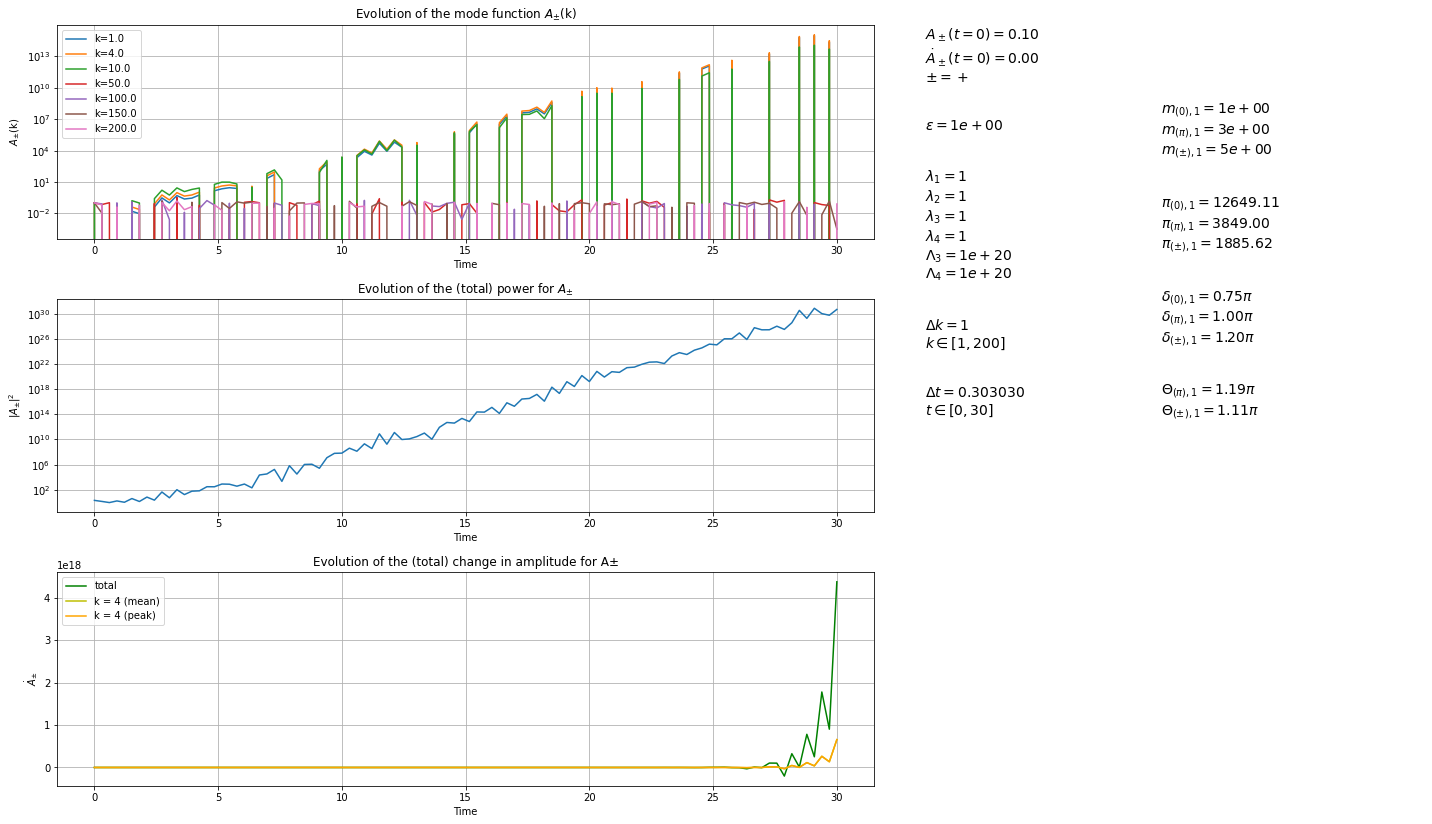

In [11]:
## Identify the k mode with the greatest peak amplitude, and the mode with the greatest average amplitude
# k_func : apply [func] on the time-series for each k mode, e.g. max or mean
k_func = lambda func: np.array([k_fval for k_fi, k_fval in enumerate([func(np.abs(solutions[k_vi][0][:])) for k_vi, k_v in enumerate(k_values)])])
# k_sens : apply [k_func] but limit the time-series by [sens], e.g. sens = 0.1 to look at the first 10%. Negative values look at the end of the array instead.
w_min  = lambda sens: int(t_N*(1./2)*np.abs(((1. - sens)*np.sign(sens) + (1. - sens))))  # min value / left endpoint (of the sensitivity window over which to average)
w_max  = lambda sens: int(t_N*(1./2)*np.abs(((1. + sens)*np.sign(sens) + (1. - sens))))  # max value / right endpoint
k_sens = lambda func, sens: np.array([k_fval for k_fi, k_fval in enumerate([func(np.abs(solutions[k_vi][0][w_min(sens):w_max(sens)])) for k_vi, k_v in enumerate(k_values)])])
#k_sens = lambda func, sens: np.array([k_fval for k_fi, k_fval in enumerate([func(np.abs(solutions[k_vi][0][int(t_span[1]*(1. - sens)):])) for k_vi, k_v in enumerate(k_values)])])
# k_ratio: apply [k_func] to each k mode and then return the ratio of the final vs. initial ampltidues (sensitive to a windowed average specified by [sens])
k_ratio = lambda func, t_sens, A_sens: np.array([k_f/k_i for k_f, k_i in zip(k_sens(func, t_sens), k_sens(func, -t_sens))])
# k_class: softly classify the level of resonance according to the final/initial mode amplitude ratio, governed by [func, t_sens, and A_sens]
k_class = lambda func, t_sens, A_sens: np.array(["damp" if k_r <= 0.9 else "none" if k_r <= (1. + np.abs(A_sens)) else "semi" if k_r <= res_con else "res" for k_r in k_ratio(func, t_sens, A_sens)])

# k mode(s) with the largest contributions to overall number density growth
k_peak = k_values[np.ma.argmax(k_func(max))]
k_mean = k_values[np.ma.argmax(k_func(np.ma.mean))]

print("max (peak) k mode: "+str(k_peak))
print("max (mean) k mode: "+str(k_mean))

# Plot the solution
signstr = {1: "+", -1: "-", 0: "±"}
#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [0,1,10,50,100,150,200,k_peak,k_mean]]
times = t
plot_Adot = True

xdim = 5
if plot_Adot:
    ydim = 3 
else:
    ydim = 2

plt.figure(figsize=(4*xdim, 4*ydim))

#plt.subplot(2,1,1)
plt.subplot2grid((ydim,xdim), (0,0), colspan=3)
for k_sample in k_samples:
    k_s = int(k_sample)
    #print(solutions[k_s, 0])
    plt.plot(times, solutions[k_s][0], label='k='+str(k_values[k_s]))
plt.title('Evolution of the mode function $A_{'+signstr[0]+'}$(k)')
plt.xlabel('Time')
plt.ylabel('$A_{'+signstr[0]+'}$(k)')
plt.yscale('log')
plt.legend()
plt.grid()

#plt.subplot(2,1,2)
plt.subplot2grid((ydim,xdim), (1,0), colspan=3)
plt.plot(times, [sum([np.abs(solutions[i][0][t_i])**2 for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Evolution of the (total) power for $A_{'+signstr[0]+'}$')
plt.xlabel('Time')
plt.ylabel('$|A_{'+signstr[0]+'}|^2$')
plt.yscale('log')
plt.grid()


if plot_Adot:
    #plt.subplot(2,1,2)
    plt.subplot2grid((ydim,xdim), (2,0), colspan=3)
    plt.plot(times, [sum([solutions[i][1][t_i] for i in range(len(k_values))]) for t_i in range(len(times))], color='g', label='total')
    plt.plot(times, [solutions[list(k_values).index(k_mean)][1][t_i] for t_i in range(len(times))], color='y', label='k = %d (mean)' % k_mean)
    plt.plot(times, [solutions[list(k_values).index(k_peak)][1][t_i] for t_i in range(len(times))], color='orange', label='k = %d (peak)' % k_peak)
    plt.title('Evolution of the (total) change in amplitude for A'+signstr[0])
    plt.xlabel('Time')
    plt.ylabel('$\dot{A}_{'+signstr[0]+'}$')
    #plt.yscale('log')
    plt.legend()
    plt.grid()

#print(len(d[0]))
    
textstr1, textstr2 = get_text_params()

plt.subplot2grid((ydim,xdim), (max(0,ydim-3),3), rowspan=2)
plt.text(0.15, 0.2, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((ydim,xdim), (max(0,ydim-3),4), rowspan=2)
plt.text(0, 0.2, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

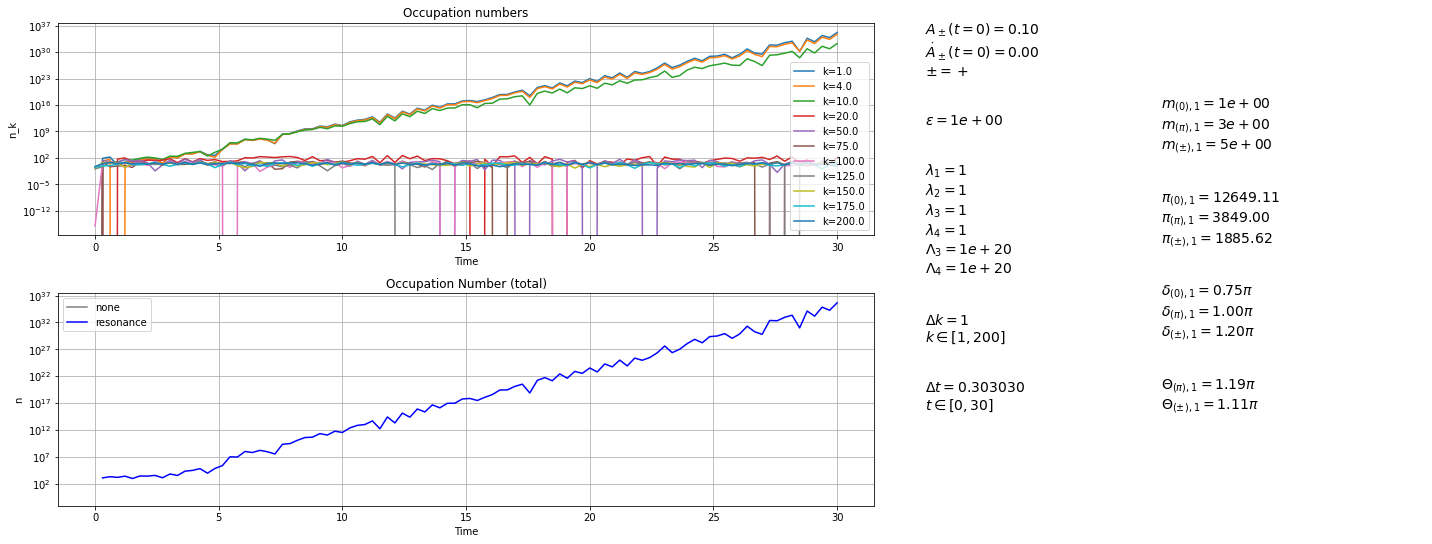

n_tot in range [5.00e-01, 4.35e+35]
resonance classification begins at t = 0.30, n = 1247.41


In [12]:
# Plot the occupation numbers
w = lambda i: np.abs(k_values[i])
n = lambda i: (w(i)/2) * (((np.square(np.abs(solutions[i][1])))/(np.square(w(i)))) + np.square(np.abs(solutions[i][0]))) - (1/2)
times = t
scale_n = False

#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [0,1,10,20,50,75,100,125,150,175,200,k_peak,k_mean]]
plt.figure(figsize=(20, 8))

plt.subplot2grid((2,5), (0,0), colspan=3)
for k_sample in k_samples:
    k_s = int(k_sample)
    plt.plot(times, n(k_s), label='k='+str(k_values[k_s]))
plt.title('Occupation numbers')
plt.xlabel('Time')
#plt.xlim(0,0.2)
plt.ylabel('n_k')
plt.yscale('log'); #plt.ylim(bottom = 0.1)
plt.legend()
plt.grid()

n_tot = np.array([sum([n(i)[t_i] for i in range(len(k_values))]) for t_i in range(len(times))])
if scale_n:
    n_tot /= abs(min(n_tot))
    n_tot += 1

#tot_res = 'resonance' if n_tot[-1]/n_tot[0] > 100 else 'none'
tot_res = 'resonance' if sum(k_ratio(np.ma.mean, t_sens, A_sens)) > res_con else 'none'
t_res_i = np.ma.argmax(np.array(n_tot) > res_con)
t_res   = t[t_res_i]
n_res   = n_tot[t_res_i]
parameters['res_class'] = tot_res
parameters['t_res'] = t_res
#n_res = res_con*sum(k_sens(np.mean, -t_sens))

#with plt.xkcd():
plt.subplot2grid((2,5), (1,0), colspan=3)
#fig,ax = plt.subplots()
#plt.plot(np.ma.masked_where(t >= t_res, times), np.ma.masked_where(np.array(n_tot) > res_con*sum(k_sens(np.mean, -t_sens)), n_tot), label='none', color='grey')
plt.plot(np.ma.masked_greater_equal(times, t_res), n_tot, label='none', color='grey')
plt.plot(np.ma.masked_less(times, t_res), n_tot, label='resonance', color='blue')
plt.title('Occupation Number (total)')
plt.xlabel('Time')
#plt.xlim(0,0.1)
plt.ylabel('n')
plt.yscale('log')
plt.legend()
plt.grid()

textstr1, textstr2 = get_text_params()

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.2, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.2, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print('n_tot in range [%.2e, %.2e]' % (min(n_tot),max(n_tot)))
if "res" in tot_res:
    print("resonance classification begins at t = %.2f, n = %.2f" % (t_res, n_res))

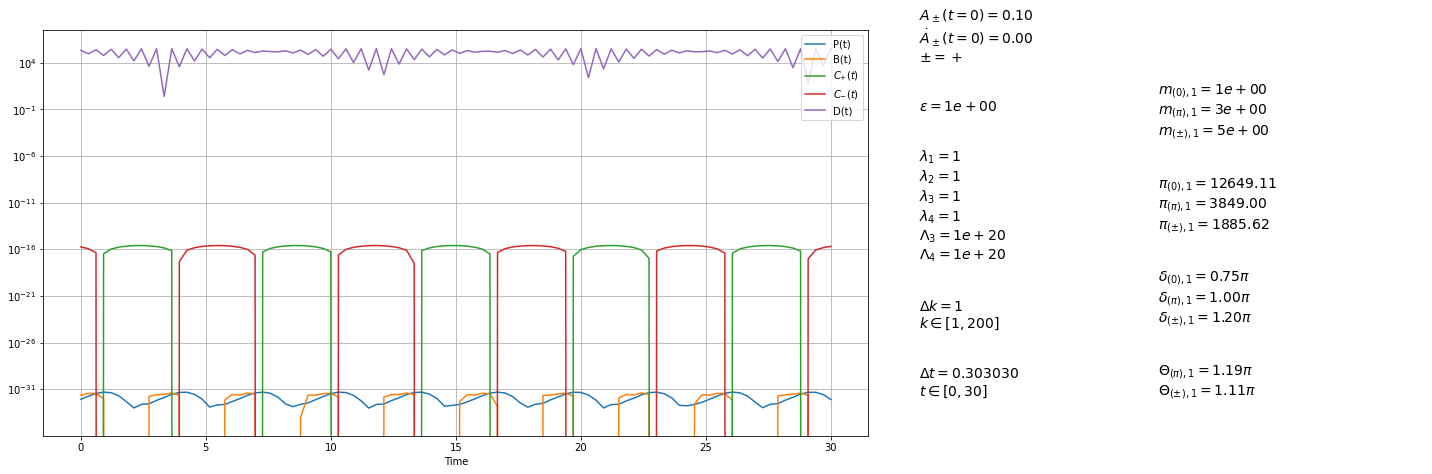

P(t) range: [9.5e-34, 4.9e-32]
B(t) range: [-5.9e-32, 3.9e-32]
C(t) range: [-2.5e-16, 2.5e-16] for + case
C(t) range: [-2.5e-16, 2.5e-16] for - case
D(t) range: [2.4e+00, 3.2e+05]


In [13]:
# Compare model coefficient values over time
plt.figure(figsize = (20,7))
times = t

plt.subplot2grid((2,5), (0,0), colspan=3, rowspan=2)

plt.plot(times, P(times),label="P(t)")
plt.plot(times, B(times),label="B(t)")
plt.plot(times, C(times,+1),label="$C_{%s}(t)$" % signstr[+1])
plt.plot(times, C(times,-1),label="$C_{%s}(t)$" % signstr[-1])
plt.plot(times, D(times),label="D(t)")

plt.xlabel('Time')
plt.yscale('log')
plt.grid()
plt.legend()

textstr1, textstr2 = get_text_params()

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.1, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.1, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

print("P(t) range: [%.1e, %.1e]" % (min(P(times)),max(P(times))))
print("B(t) range: [%.1e, %.1e]" % (min(B(times)),max(B(times))))
print("C(t) range: [%.1e, %.1e] for + case" % (min(C(times, +1)),max(C(times, +1))))
print("C(t) range: [%.1e, %.1e] for - case" % (min(C(times, -1)),max(C(times, -1))))
print("D(t) range: [%.1e, %.1e]" % (min(D(times)),max(D(times))))


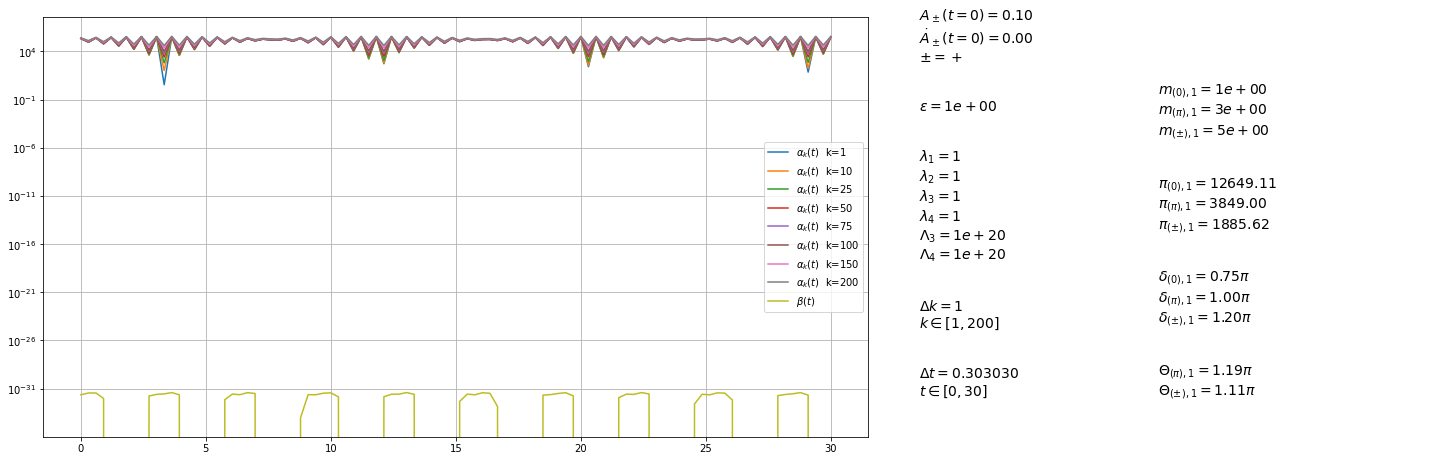

Alpha(t) range: [3.4e+00, 3.2e+05] when k = 1
Alpha(t) range: [1.0e+02, 3.2e+05] when k = 10
Alpha(t) range: [6.3e+02, 3.2e+05] when k = 25
Alpha(t) range: [2.5e+03, 3.2e+05] when k = 50
Alpha(t) range: [5.6e+03, 3.3e+05] when k = 75
Alpha(t) range: [1.0e+04, 3.3e+05] when k = 100
Alpha(t) range: [2.3e+04, 3.4e+05] when k = 150
Alpha(t) range: [4.0e+04, 3.6e+05] when k = 200
Beta(t) range: [-5.9e-32, 3.9e-32]


In [14]:
# Compare Alpha(t) and Beta(t) for a sampling of k values
times = t
Alpha = lambda t, k: (k**2 + C(t, A_pm)*k + D(t)) / (1 + P(t))
Beta = lambda t: B(t) / (1 + P(t))

plt.figure(figsize = (20,7))
plt.subplot2grid((2,5), (0,0), colspan=3, rowspan=2)

#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [0,1,10,25,50,75,100,150,200]]
for k_sample in k_samples:
    k_s = int(k_sample)
    plt.plot(times, Alpha(times, k_values[k_s]), label=r"$\alpha_k(t)$  k=%d" % k_values[k_s])

plt.plot(times, Beta(times), label=r"$\beta(t)$")

plt.grid()
plt.yscale('log')
plt.legend()

textstr1, textstr2 = get_text_params()

plt.subplot2grid((2,5), (0,3), rowspan=2)
plt.text(0.15, 0.1, textstr1, fontsize=14)
plt.axis('off')

plt.subplot2grid((2,5), (0,4), rowspan=2)
plt.text(0, 0.1, textstr2, fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

for k_s in k_samples:
    print("Alpha(t) range: [%.1e, %.1e] when k = %d" % (min(Alpha(times, k_values[k_s])), max(Alpha(times, k_values[k_s])), k_values[k_s]))
print("Beta(t) range: [%.1e, %.1e]" % (min(Beta(times)), max(Beta(times))))

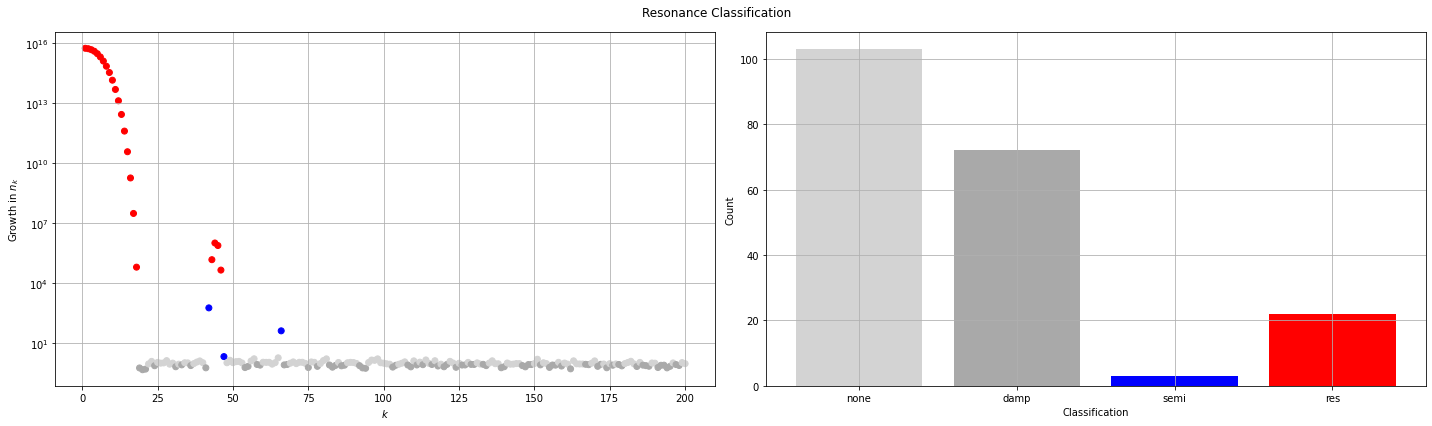

In [15]:
#print(params)

# store max, all-time mean, and late-time mean for each k-mode
params["k_peak_arr"] = k_func(max)
params["k_mean_arr"] = k_func(np.mean)
params["k_sens_arr"] = k_sens(np.mean, t_sens)
params["k_class_arr"] = k_class(np.mean, t_sens, A_sens)

params["class"] = tot_res

#print(params["class"])
#print(params["k_class_arr"])

class_colors = {'none': 'lightgrey', 'damp': 'darkgrey', 'semi': 'blue', 'res': 'red'}
#print(k_class(np.mean, t_sens, A_sens))
#print(k_ratio(np.mean, t_sens, A_sens))

plt.figure(figsize = (20,6))
plt.suptitle('Resonance Classification')

plt.subplot2grid((2,4), (0,0), colspan=2, rowspan=2)
plt.scatter(k_values, k_ratio(np.mean, t_sens, A_sens), c=[class_colors[k_c] if k_c in class_colors else 'orange' for k_c in k_class(np.mean, t_sens, A_sens)])
plt.xlabel('$k$')
plt.ylabel('Growth in $n_k$')
plt.yscale('log')
plt.grid()

plt.subplot2grid((2,4), (0,2), colspan=2, rowspan=2)
#plt.bar(k_values,k_ratio(np.mean, t_sens, A_sens),color=[class_color(k_c) for k_c in k_class(np.mean, t_sens, A_sens)])
class_counts = [(np.array(k_class(np.mean, t_sens, A_sens)) == class_label).sum() for class_label in class_colors.keys()]
plt.bar(class_colors.keys(),class_counts,color=class_colors.values())
plt.xlabel('Classification')
plt.ylabel('Count')
plt.grid()

plt.tight_layout()
plt.show()